In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers.create_histograms import *
from helpers.visualize_data import *

In [5]:
datadir_input = "data/raw_data/"
datadir_output = "data/generated_histograms/"

In [6]:
# m_mumu energy interval (110.,160.) GeV for Higgs
x_range = (110, 160) # change this!

# if n_bins is an int, it defines the number of equal-width bins in the given range
# if n_bins is a sequence, it defines a monotonically increasing array of bin edges, allowing for non-uniform bin widths
n_bins = 60 # change this!

# filenames of downloaded input .h5 files
dataset_names = ["mc_bkg_new", "mc_sig", "data"]

# labels for file content
labels = ["Background", "Signal", "Data"]

# name of the saved histograms
save_hist_name = "my_hist"

# dictionary from labels to file names
hists_files = {label: f"{datadir_output}{save_hist_name}_{label}.npz" for label in labels}

# check if all histograms already exist
already_exists = all([os.path.isfile(f) for f in hists_files.values()])

# if not all histogram .npz files found, make histograms
if not already_exists:
    dirs = make_histograms(
        datadir_input,
        datadir_output,
        labels,
        dataset_names,
        n_bins,
        x_range=x_range,
        save_hist_name=save_hist_name,
    )

Loading data/raw_data/mc_bkg_new.h5...
Creating histogram for Background...
Loading data/raw_data/mc_sig.h5...
Creating histogram for Signal...
Loading data/raw_data/data.h5...
Creating histogram for Data...


In [9]:
def load_histogram(hist_file):
    with np.load(hist_file, "rb") as data:
        bin_edges = data["bin_edges"]
        bin_centers = data["bin_centers"]
        bin_values = data["bin_values"]
        bin_errors = data["bin_errors"]

    return {"centers": bin_centers, "edges": bin_edges, "values": bin_values, "errors": bin_errors}

In [10]:
hists = {}

for hist_label, hist_file in hists_files.items():
    hists[hist_label] = load_histogram(hist_file)

In [11]:
# we can now access histogram contents with label key and one of the histogram data keys
hists.keys(), hists["Background"].keys()

(dict_keys(['Background', 'Signal', 'Data']),
 dict_keys(['centers', 'edges', 'values', 'errors']))

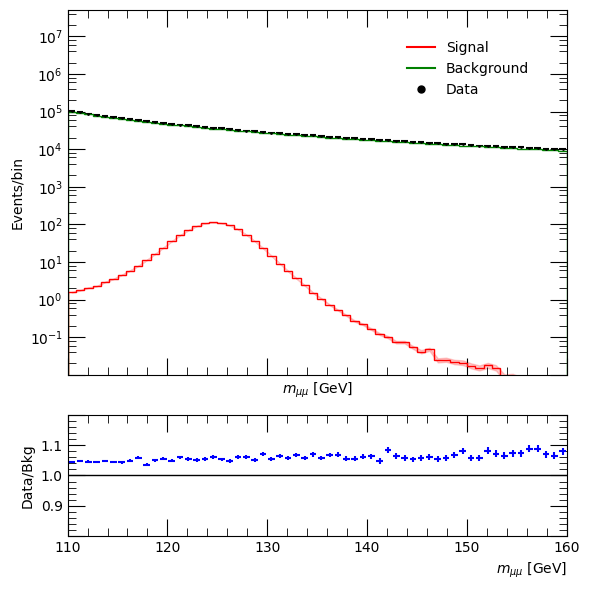

In [14]:
# using helpers
from helpers.visualize_data import visualize_histograms

visualize_histograms(hists.keys(), save_hist_name, "data/generated_histograms/", output_filename=None, save=False)
plt.tight_layout()